# Modelling and Evaluation Notebook


## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given leaf contains a mildew or not.

## Inputs

* Inputs/mildew_dataset/cherry-leaves/train
* Inputs/mildew_dataset/cherry-leaves/test
* Inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:

current_dir = os.getcwd()
current_dir

'/workspace/mildewprac/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildewprac'

## Set input directories

In [5]:
data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

## Set output directory


In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


---

## Set image shape


In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

# Number of images in train, test and validation data


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




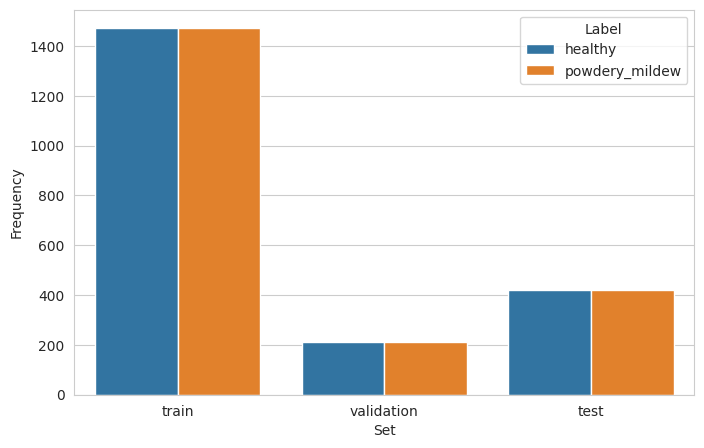

In [29]:
data = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = len(os.listdir(data_dir + '/' + folder + '/' + label))
        data.append({
            'Set': folder,
            'Label': label,
            'Frequency': frequency
        })
        print(f"* {folder} - {label}: {frequency} images")
df_freq = pd.DataFrame(data)
print("\n")

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

ImageDataGenerator

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [31]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                         width_shift_range=0.10,
                                         height_shift_range=0.10,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest',
                                         rescale=1./255
                                         )

* ### Augment training image dataset

In [35]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True)
train_set.class_indices                                    

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [36]:
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                                val_path,
                                                                target_size=image_shape[:2],
                                                                color_mode='rgb',
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                shuffle=False)
val_set.class_indices                              

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [37]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


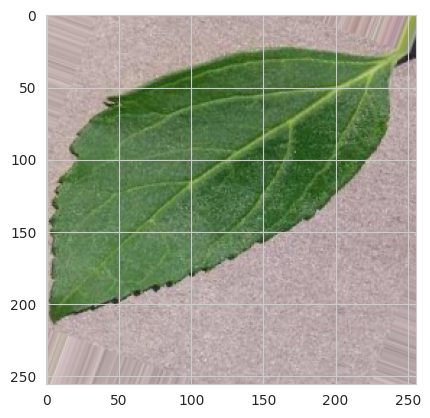

(20, 256, 256, 3)


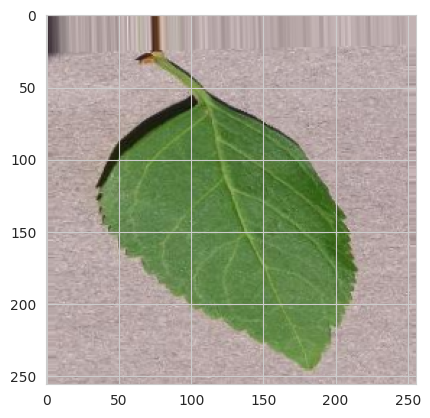

(20, 256, 256, 3)


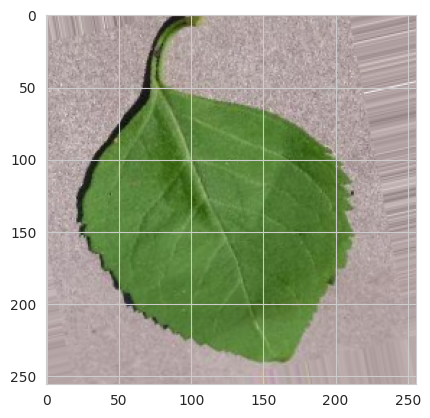

In [42]:
for _ in range(3):
    img, label = next(iter(train_set))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 256, 256, 3)


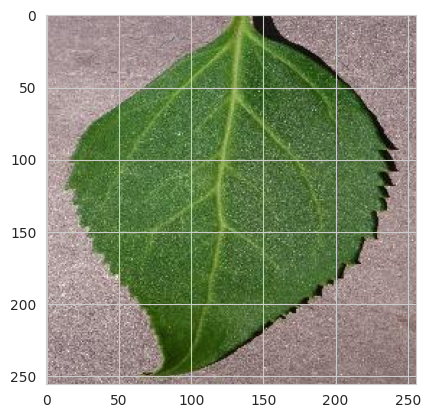

(20, 256, 256, 3)


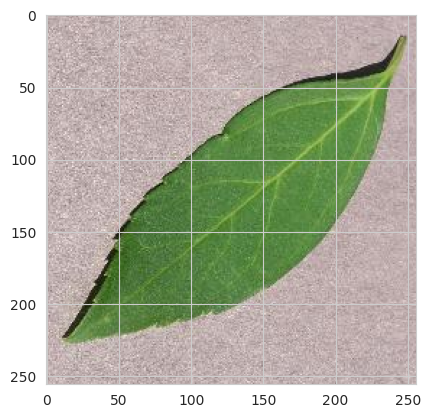

(20, 256, 256, 3)


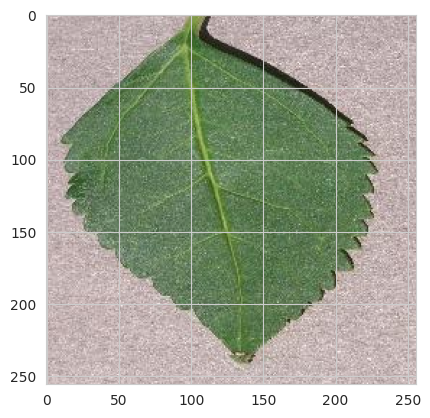

In [43]:
for _ in range(3):
    img, label = next(iter(val_set))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


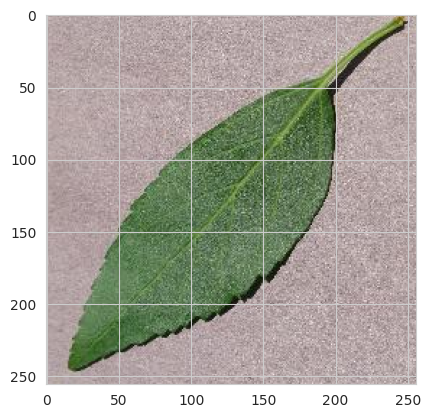

(20, 256, 256, 3)


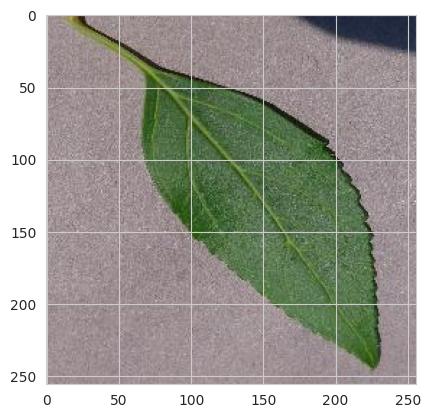

(20, 256, 256, 3)


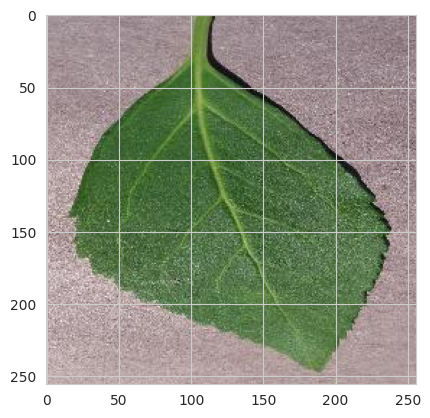

In [44]:
for _ in range(3):
    img, label = next(iter(test_set))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [45]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model Creation

---

## ML Model

* ###  Import model packages

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model

In [47]:
def create_tf_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

* ### Model Summary

In [48]:
create_tf_model().summary()

/workspace/mildewprac/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for training 

In [50]:
model = create_tf_model()
model.fit(train_set, epochs=25, steps_per_epoch=len(train_set
.classes) // batch_size, validation_data=val_set, callbacks=[early_stop], verbose=1)

/workspace/mildewprac/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/25


/workspace/mildewprac/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.7370 - loss: 0.4829 - val_accuracy: 0.9714 - val_loss: 0.0757
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9000 - loss: 0.2896

2024-03-05 13:40:23.469175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/gitpod/.pyenv/versions/3.12.2/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9000 - loss: 0.1458 - val_accuracy: 0.9833 - val_loss: 0.0742
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9839 - loss: 0.0552 - val_accuracy: 0.9857 - val_loss: 0.1016
Epoch 4/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:21 969ms/step - accuracy: 1.0000 - loss: 0.0378

2024-03-05 13:44:21.389046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.9857 - val_loss: 0.0959
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9833 - loss: 0.0435 - val_accuracy: 0.9810 - val_loss: 0.0721
Epoch 6/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 1.0000 - loss: 0.0339

2024-03-05 13:48:03.028611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.9810 - val_loss: 0.0700
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9907 - loss: 0.0331 - val_accuracy: 0.9857 - val_loss: 0.0648
Epoch 8/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 1.0000 - loss: 1.9830e-04

2024-03-05 13:52:35.737965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 1.0000 - loss: 9.9824e-05 - val_accuracy: 0.9857 - val_loss: 0.0727
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9955 - loss: 0.0167 - val_accuracy: 0.9881 - val_loss: 0.0595
Epoch 10/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 1.0000 - loss: 0.0080

2024-03-05 13:57:11.633269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9857 - val_loss: 0.0682
Epoch 11/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9893 - loss: 0.0247 - val_accuracy: 0.9952 - val_loss: 0.0208
Epoch 12/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - accuracy: 0.9500 - loss: 0.1223

2024-03-05 14:01:18.617142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9500 - loss: 0.0615 - val_accuracy: 0.9976 - val_loss: 0.0227
Epoch 13/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9827 - loss: 0.0514 - val_accuracy: 0.9881 - val_loss: 0.0361
Epoch 14/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:28 1s/step - accuracy: 1.0000 - loss: 0.0017

2024-03-05 14:05:00.953260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 1.0000 - loss: 8.3095e-04 - val_accuracy: 0.9952 - val_loss: 0.0252


## Save Model

In [51]:
model.save('outputs/v1/mildew_model.h5')

---

# Model Performance

---

## Model Learning Curve

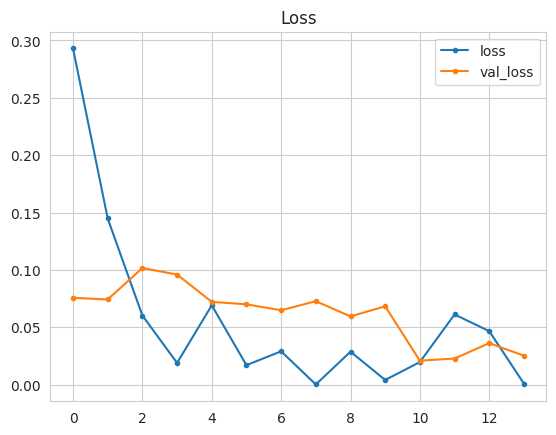

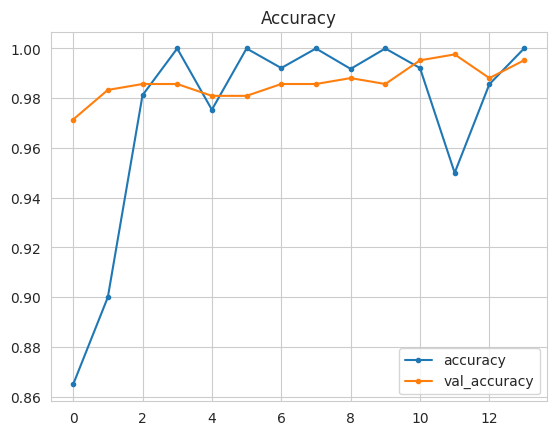

In [52]:
losses = pd.DataFrame(model.history.history)

sns.set_style('whitegrid')

losses[['loss', 'val_loss']].plot(style='.-')
plt.title('Loss')
plt.savefig(f'{file_path}/model_train_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print('\n')
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.savefig(f'{file_path}/model_train_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [53]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_model.h5')

Evaluate model on test set

In [54]:
evaluation = model.evaluate(test_set)

/workspace/mildewprac/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - accuracy: 0.9999 - loss: 0.0012 


### Save Evaluation Pickle

In [55]:
joblib.dump(value=evaluation, filename=f'outputs/v1/evaluation.pkl')

['outputs/v1/evaluation.pkl']

## Predict On New Data 

Load random image as PIL

Image shape: (256, 256), Image Mode: RGB


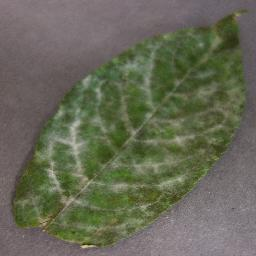

In [58]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image Mode: {pil_image.mode}')
pil_image                           

Convert image to array for prediction

In [59]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [60]:
pred_prob = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_prob > 0.5]

if pred_class == target_map[0]:
    pred_prob = 1 - pred_prob

print(pred_prob)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
0.9999995
powdery_mildew


# Push files to repo

In [61]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

In [62]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/04-Modeling&Evaluation.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/class_indices.pkl
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/mildew_model.h5
	outputs/v1/model_train_acc.png
	outputs/v1/model_train_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


In [63]:
!git add .

In [64]:
!git commit -am "Add new plots"

[main 81ec3eb] Add new plots
 7 files changed, 1410 insertions(+), 39 deletions(-)
 create mode 100644 outputs/v1/class_indices.pkl
 create mode 100644 outputs/v1/evaluation.pkl
 create mode 100644 outputs/v1/labels_distribution.png
 create mode 100644 outputs/v1/mildew_model.h5
 create mode 100644 outputs/v1/model_train_acc.png
 create mode 100644 outputs/v1/model_train_losses.png


In [65]:
!git push

Enumerating objects: 26, done.
Counting objects: 100% (26/26), done.
Delta compression using up to 16 threads
Compressing objects: 100% (18/18), done.
Writing objects: 100% (23/23), 75.61 MiB | 10.59 MiB/s, done.
Total 23 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 2 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/mildew_model.h5 is 85.06 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/rimanfarhood/mildewprac.git
   cae56a6..81ec3eb  main -> main
